In [1]:
import torch
import numpy as np
import cv2
import os 
import pandas as pd
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch.functional import img_to_tensor
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm

In [2]:
# Creation of combined CSV file with Greece and our Kaspi Datasets

# f_t = pd.read_csv('train.csv')
# f_v = pd.read_csv('valid.csv')

# s_t = pd.read_csv('Custom Dataset/train.csv')
# s_v = pd.read_csv('Custom Dataset/valid.csv')


# new_t = pd.concat([f_t, s_t])
# new_v = pd.concat([f_v, s_v])

# new_t.to_csv(f'Custom Dataset/train valid combined csv/train.csv', index=False)
# new_v.to_csv(f'Custom Dataset/train valid combined csv/valid.csv', index=False)

In [3]:
from helpers.config import load_config
from helpers.utils import create_optimizer, AverageMeter
from helpers.losses import miou_round, val_miou_round
from helpers import losses
conf = load_config('helpers/effb5_conf.json') 

In [4]:
#helpers5classes
#helpers

In [5]:
PTH = 'Oil Spill Detection Dataset/'

In [6]:
train = os.path.join(PTH, 'train/images')
train_mask = os.path.join(PTH, 'train/labels')

valid = os.path.join(PTH, 'test/images')
valid_mask = os.path.join(PTH, 'test/labels')

# Create transforms

In [7]:
def create_train_transforms():
    #(650,1250) > 512x512 > 512x512 > (650x1250) > 
    
    return A.Compose([
        A.RandomCrop(640, 640, p=1.0),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=.1),
            A.Blur(blur_limit=3, p=.1),
        ], p=1.0),
        A.Transpose(p=0.5),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
        A.RandomGamma(p=0.5),
        A.ElasticTransform(alpha=10, sigma=150, alpha_affine=50, interpolation=1, border_mode=4, value=17, mask_value=105, p=0.5),
        A.OneOf([
            A.GridDistortion(p=0.5), #num_steps=50, distort_limit=0.5, interpolation=1, border_mode=4, value=None, mask_value=None, 
            A.OpticalDistortion(p=0.5)
        ], p=1.0),
        
        A.VerticalFlip(p=0.5)
    ])


def create_val_transforms():
    return A.Compose([
        A.Crop(0,0,640,640, p=1.0)
    ])

# Convert RGB mask to 1D mask

In [8]:
def rgb_to_label(rgb_mask):
    color_to_label = {
        (0,0,0): 0,
        (0,255,255): 1,
        (255,0,0): 2,
        (153, 76,0): 3,
        (0,153,0): 4
    }
    height, width, _ = rgb_mask.shape
    label_mask = np.zeros((height, width), dtype = np.uint8)
    
    for color, label in color_to_label.items():
        indices = np.where(np.all(rgb_mask==color, axis=-1))
        #print(indices)
        label_mask[indices] = label
    return label_mask

In [9]:
rgb_mask = cv2.imread('Oil Spill Detection Dataset/train/labels/42_916,10_638_3.png')

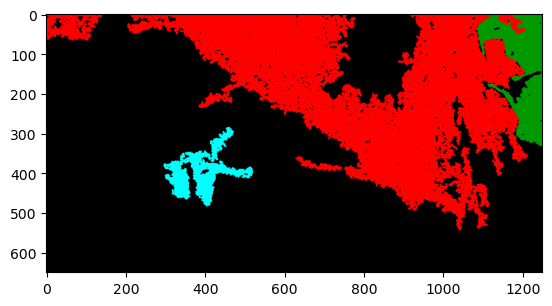

In [10]:
plt.imshow(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

In [11]:
label_mask = rgb_to_label(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

In [12]:
label_mask[label_mask!=1] = 0

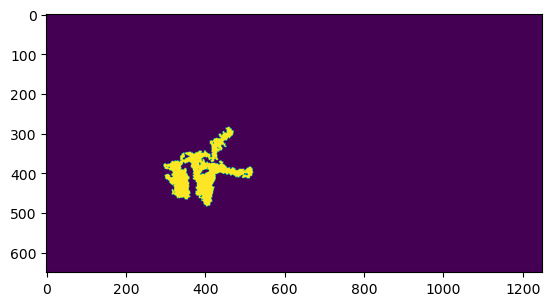

In [13]:
plt.imshow(label_mask)

In [14]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

# Create CSV with common file names

In [15]:
# def common_ims(img_pth, mask_pth, mode):
#     img_ids = os.listdir(img_pth)
#     mask_ids = os.listdir(mask_pth)
#     mask_ids = [s.replace('png', 'jpg') for s in mask_ids]
    
#     img_df = pd.DataFrame({'filename': img_ids})
#     mask_df = pd.DataFrame({'filename': mask_ids})

#     merged_df = pd.merge(img_df, mask_df, on='filename')
#     merged_df.to_csv(f'{mode}.csv', index=False)

In [16]:
# common_ims(train, train_mask, 'train')
# common_ims(valid, valid_mask, 'valid')

In [17]:
train_df = pd.read_csv('Custom Dataset/train valid combined csv/train.csv')
test_df = pd.read_csv('Custom Dataset/train valid combined csv/valid.csv')

In [18]:
train_df.head()

,filename
0,"27_884,-17_39_2.jpg"
1,"27_884,-17_39_3.jpg"
2,"27_884,-17_39_4.jpg"
3,"27_884,-17_39_5.jpg"
4,"29_379,-11_01_1.jpg"


In [19]:
train_df.tail()

,filename
1219,0014/5.png
1220,0014/6.png
1221,0014/7.png
1222,0014/8.png
1223,0014/9.png


In [20]:
len(os.listdir(train)), len(os.listdir(train_mask))

(1002, 1002)

# Dataset

In [21]:
class OilDataset(Dataset):
    def __init__(self, df, mode='train', classes=None, augmentations = None, normalize = None):
        self.df = df['filename']
        self.mode = mode
        self.classes = classes
        self.augmentations = augmentations
        self.normalize = normalize
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        if '/' in self.df[idx]:
            image = cv2.imread(os.path.join(f'Custom Dataset/{self.mode}/images/', self.df[idx]))
            mask = cv2.imread(os.path.join(f'Custom Dataset/{self.mode}/masks/', self.df[idx]))#.replace('jpg', 'png')))
        else:
            image = cv2.imread(os.path.join(f'Oil Spill Detection Dataset/{self.mode}/images/', self.df[idx]))
            mask = cv2.imread(os.path.join(f'Oil Spill Detection Dataset/{self.mode}/labels/', self.df[idx].replace('jpg', 'png')))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = rgb_to_label(mask) # (0,255,255) > 1, .... -> 0, ... -> 2
        
        mask[mask!=1] = 0
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            #image, mask = sample['image'], sample['mask']
        
        mask = np.zeros((self.classes, *sample["mask"].shape[:2]))
        for i in range(self.classes):
            mask[i, sample["mask"] == i] = 1
        
        if '/' in self.df[idx]:
            sample['img_name'] = os.path.join(f'Custom Dataset/{self.mode}/images/', self.df[idx])
        else:
            sample['img_name'] = os.path.join(f'Oil Spill Detection Dataset/{self.mode}/images/', self.df[idx])
            
        sample['mask_orig'] = sample['mask']
        sample['mask'] = torch.from_numpy(np.ascontiguousarray(mask)).float()
        sample['image'] = img_to_tensor(np.ascontiguousarray(sample['image']), self.normalize)
        return sample
        
        

In [22]:
dataset = OilDataset(train_df, mode='train', classes = 2, augmentations=create_train_transforms(), normalize = conf['input']['normalize'])

In [23]:
dataset[0]['image'].shape, dataset[0]['img_name'], dataset[0]['mask'].shape, dataset[0]['mask_orig'].shape


(torch.Size([3, 640, 640]),
 'Oil Spill Detection Dataset/train/images/27_884,-17_39_2.jpg',
 torch.Size([2, 640, 640]),
 (640, 640))

# Config

# Train

In [24]:
def train_epoch(current_epoch, loss_functions, model, optimizer, scheduler, train_data_loader, 
                summary_writer, conf):
    losses = AverageMeter()
    mious = AverageMeter()
    iterator = tqdm(train_data_loader)
    model.train()
    if conf["optimizer"]["schedule"]["mode"] == "epoch":
        scheduler.step(current_epoch)
    for i, sample in enumerate(iterator):
        imgs = sample["image"].cuda()
        masks = sample["mask"].cuda().float()
        masks_orig = sample["mask_orig"].cuda().float()
        out_mask = model(imgs)
        with torch.no_grad():
            pred = torch.softmax(out_mask, dim=1)
            argmax = torch.argmax(pred, dim=1)
            ious = miou_round(argmax, masks_orig).item()

        mious.update(ious, imgs.size(0))

        mask_loss = loss_functions["mask_loss"](out_mask, masks.contiguous())
        loss = mask_loss
        losses.update(loss.item(), imgs.size(0))
        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss ({loss.avg:.4f}); miou ({miou.avg:.4f}); ".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, miou=mious))
        optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        #torch.cuda.synchronize()

        if conf["optimizer"]["schedule"]["mode"] in ("step", "poly"):
            scheduler.step(i + current_epoch * len(train_data_loader))
   
    for idx, param_group in enumerate(optimizer.param_groups):
        lr = param_group['lr']
        summary_writer.add_scalar('group{}/lr'.format(idx), float(lr), global_step=current_epoch)
    summary_writer.add_scalar('train/loss', float(losses.avg), global_step=current_epoch)

In [25]:
def validate(net, data_loader, predictions_dir):
    os.makedirs(predictions_dir, exist_ok=True)
    preds_dir = predictions_dir + "/predictions"
    os.makedirs(preds_dir, exist_ok=True)
    mious = []
    oil_class_iou = []
    with torch.no_grad():
        for sample in tqdm(data_loader):
            imgs = sample["image"].cuda().float()
            mask_orig = sample["mask_orig"].cuda().float()

            output = net(imgs)
            pred = torch.softmax(output, dim=1)
            argmax = torch.argmax(pred, dim=1)

            for i in range(output.shape[0]):
                d, ious = val_miou_round(argmax, mask_orig)
                
                mious.append(d.item())
                oil_class_iou.append(ious[1].item())
                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_prediction.png"),
                            argmax[i].cpu().numpy().astype(np.uint8) * 64)

                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_mask_orig.png"),
                            mask_orig[i].cpu().numpy().astype(np.uint8) * 64)
    print(np.mean(oil_class_iou))
    return np.mean(mious)
def evaluate_val(output_dir, data_val, miou_best, model, snapshot_name, current_epoch, optimizer, summary_writer,
                 predictions_dir):
    print("Test phase")
    model = model.eval()
    miou = validate(model, data_loader=data_val, predictions_dir=predictions_dir)
    summary_writer.add_scalar('val/miou', float(miou), global_step=current_epoch)
    if miou > miou_best:
        if output_dir is not None:
            torch.save({
                'epoch': current_epoch + 1,
                'state_dict': model.state_dict(),
                'miou_best': miou,

            }, output_dir +'/' + snapshot_name + "_best_miou.pt")
        miou_best = miou
    torch.save({
        'epoch': current_epoch + 1,
        'state_dict': model.state_dict(),
        'miou_best': miou_best,
    }, output_dir + '/'+ snapshot_name + "_last.pt")
    print("miou: {}, miou_best: {}".format(miou, miou_best))
    return miou_best

In [26]:
import segmentation_models_pytorch as smp



# 1st method

In [27]:
model = smp.Unet(encoder_name='efficientnet-b5', classes=2) # effnet on ImageNet 1000 classes

# 2nd method

In [28]:
# model = smp.Unet(encoder_name='efficientnet-b7', classes=5, encoder_weights=None) # effnet on ImageNet 1000 classes
# checkpoint = torch.load('models/5 classes/Efficientnet-b7 74% Val Acc/segment_efficientnet-b7_efficientnet-b7_best_miou.pt', map_location='cpu') # 5 class Segmentation model on greece dataset
# state_dict = checkpoint['state_dict']
# model.load_state_dict(state_dict, strict=False)
# model.segmentation_head[0] = torch.nn.Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [29]:
model = model.cuda()

In [30]:
mask_loss_function = losses.__dict__[conf["mask_loss"]["type"]](**conf["mask_loss"]["params"]).cuda()
loss_functions = {"mask_loss": mask_loss_function}
optimizer, scheduler = create_optimizer(conf['optimizer'], model)

miou_best = 0
start_epoch = 0
batch_size = conf['optimizer']['batch_size']
#print(train_lst)
data_train = OilDataset(train_df,
                        mode='train', 
                        classes = 2, 
                        augmentations=create_train_transforms(), 
                        normalize = conf['input']['normalize'])
data_val = OilDataset(test_df,
                        mode='test', 
                        classes = 2, 
                        augmentations=create_val_transforms(), 
                        normalize = conf['input']['normalize'])
train_sampler = None

In [31]:
train_data_loader = DataLoader(data_train, batch_size=batch_size, 
                                   shuffle=train_sampler is None, sampler=train_sampler, pin_memory=False,
                                   drop_last=True) #num_workers=8,
#print(data_train.__getitem__(1)['image'].shape)
#print(data_train.__getitem__(1)['mask'].shape)
val_batch_size = 1
val_data_loader = DataLoader(data_val, batch_size=val_batch_size,  shuffle=False,
                             pin_memory=False) #num_workers=8,

In [32]:
#!mkdir predictions

In [33]:
output_dir = 'outputs'
predictions_path = 'predictions'

In [34]:
logdir = 'logs'
summary_writer = SummaryWriter(logdir + '/' + 'segment_' + conf['encoder'])

In [35]:
start_epoch = 0
current_epoch=0

In [36]:
snapshot_name = "{}{}_{}".format('segment_', conf['network'], conf['encoder'])

In [37]:
for epoch in range(start_epoch, conf['optimizer']['schedule']['epochs']):
        if train_sampler:
            train_sampler.set_epoch(epoch)

        model_encoder_stages = model.encoder
        model_encoder_stages.train()
        for p in model_encoder_stages.parameters():
            p.requires_grad = True
        train_epoch(current_epoch, loss_functions, model, 
                    optimizer, scheduler, train_data_loader, summary_writer, conf)

        model = model.eval()
        
        torch.save({
            'epoch': current_epoch + 1,
            'state_dict': model.state_dict(),
            'miou_best': miou_best,
        }, output_dir + '/' + snapshot_name + "_last")
        preds_dir = os.path.join(predictions_path, snapshot_name)
        miou_best = evaluate_val(output_dir, val_data_loader, miou_best, model,
                                 snapshot_name=snapshot_name,
                                 current_epoch=current_epoch,
                                 optimizer=optimizer, summary_writer=summary_writer,
                                 predictions_dir=preds_dir)
        current_epoch += 1


  0%|          | 0/612 [00:00<?, ?it/s]

C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable t

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.6547573600024961
miou: 0.824387064704331, miou_best: 0.824387064704331


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7198865145036158
miou: 0.8563902243491142, miou_best: 0.8563902243491142


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7469337232201414
miou: 0.8706120972030906, miou_best: 0.8706120972030906


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7413575236204805
miou: 0.868029811529703, miou_best: 0.8706120972030906


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7228752259696173
miou: 0.8588699100799458, miou_best: 0.8706120972030906


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7807592065734565
miou: 0.887986112826614, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.760068677858296
miou: 0.8775873736989114, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7793592878262054
miou: 0.8872855214341995, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7645364615678097
miou: 0.8799703428822179, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7717949510449468
miou: 0.8835148787306201, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7800822336369655
miou: 0.8878183640459533, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7785986923797402
miou: 0.8871717741412501, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7671716638586696
miou: 0.8812330067157745, miou_best: 0.887986112826614


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7975166897196067
miou: 0.8966044754751267, miou_best: 0.8966044754751267


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7942766804672585
miou: 0.8950348759210238, miou_best: 0.8966044754751267


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.796608748790301
miou: 0.8961230258467376, miou_best: 0.8966044754751267


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7911261844978233
miou: 0.8933687344674142, miou_best: 0.8966044754751267


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7933032954489436
miou: 0.8944969095530049, miou_best: 0.8966044754751267


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7994780715951066
miou: 0.8976036024990902, miou_best: 0.8976036024990902


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.793435138088342
miou: 0.8947089868848042, miou_best: 0.8976036024990902


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8030577205400078
miou: 0.8995279890875663, miou_best: 0.8995279890875663


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7962589276418507
miou: 0.8958072728046806, miou_best: 0.8995279890875663


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8054108677927818
miou: 0.9007190166301625, miou_best: 0.9007190166301625


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8152586352055334
miou: 0.905609596640833, miou_best: 0.905609596640833


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8158766044804147
miou: 0.9059737774954048, miou_best: 0.9059737774954048


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8168781452734951
miou: 0.9063545122582425, miou_best: 0.9063545122582425


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8007326304260816
miou: 0.8983690331700027, miou_best: 0.9063545122582425


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8340150126859941
miou: 0.9151189830354465, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8240427922947949
miou: 0.9101556999388561, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8014012258850235
miou: 0.8988202712548676, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8078759395912518
miou: 0.9020736521931105, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7834888299264402
miou: 0.8897528047523191, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7871469769884912
miou: 0.8916351391423133, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7729363807009281
miou: 0.8845108000821965, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7792322769668886
miou: 0.8873729950958683, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7834414810626957
miou: 0.889687906670314, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8084006166706015
miou: 0.9022019060068233, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8027707400207202
miou: 0.8995211842239544, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8069578963503866
miou: 0.901508123163254, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8129527001417406
miou: 0.9045004157289382, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8171577877050196
miou: 0.906647742916179, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8129585551595226
miou: 0.9045126425322666, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8077713687078704
miou: 0.9019506342949406, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8228321793733941
miou: 0.9095671603115656, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8211700475306707
miou: 0.9087031885821332, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8105376987654459
miou: 0.9033755615193356, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7879714320675325
miou: 0.8919907024791164, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8180422995962626
miou: 0.9071301250688492, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8202999387570762
miou: 0.9082868222587852, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7867125821751005
miou: 0.891439371371782, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.8038672561680202
miou: 0.9000547161345841, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

Test phase


  0%|          | 0/186 [00:00<?, ?it/s]

0.7937662527951638
miou: 0.8950075572857292, miou_best: 0.9151189830354465


  0%|          | 0/612 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#w_new = w_old - 0.0003*(dE/dw_old)  oil_spill pretrained model 0.01 > 0.00001

# 1d to RGB

In [ ]:
import numpy as np
import cv2

def convert_mask(mask):
   
    color_mappings = {
        0: (0, 0, 0),
        1: (0, 255, 255),
        2: (255, 0, 0),
        3: (153, 76, 0),
        4: (0, 153, 0)
    }

   
    height, width= mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

   
    for class_idx, color in color_mappings.items():
        class_mask = (mask == class_idx)
        rgb_mask[class_mask] = color

    
    return rgb_mask


In [ ]:
img1 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_mask_orig.png')
img2 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_prediction.png')

In [ ]:
img1 = img1/64
img2 = img2/64

In [ ]:
plt.imshow(img1)

In [ ]:
plt.imshow(img2)

In [ ]:
plt.imshow(convert_mask(img1[:,:,1]))

In [ ]:
plt.imshow(convert_mask(img2[:,:,1]))

In [ ]:
img[:,:,1].shape

In [ ]:
# 650x1250 > 